# demo: TextGraph + LLMs to construct a 'lemma graph'

_TextGraph_ library is intended for iterating through a sequence of paragraphs.

## intro

In [1]:
import pathlib
from IPython.display import display, HTML, Image
display(HTML(pathlib.Path("docs/demo/blurb.1.html").read_text(encoding = "utf-8")))

## parse a document

In [2]:
from icecream import ic
from pyinstrument import Profiler
import matplotlib.pyplot as plt
import pandas as pd
import pyvis
import spacy

import textgraph

provide the source text

In [3]:
SRC_TEXT: str = """                                                                                                                      
Werner Herzog is a remarkable filmmaker and an intellectual originally from Germany, the son of Dietrich Herzog.
Although in fact Werner Herzog never really liked his father, as we all know.
After the war, Werner fled to America to become famous.
"""

set up the statistical stack profiling

In [4]:
profiler: Profiler = Profiler()
profiler.start()

set up the `TextRank` pipeline

In [6]:
tg: textgraph.TextGraph = textgraph.TextGraph(
    factory = textgraph.PipelineFactory(
        spacy_model = textgraph.SPACY_MODEL,
        ner_model = None,
        nre_model = textgraph.NRE_MODEL,
        dbpedia_spotlight_api = textgraph.DBPEDIA_SPOTLIGHT_API,
    ),
)

pipe: textgraph.Pipeline = tg.create_pipeline(
    SRC_TEXT.strip(),
)

2023-12-12 12:22:49,579 - root - INFO - Initializing word embedding with word2vec.


## visualize the parse results

In [7]:
spacy.displacy.render(
    pipe.ent_doc,
    style = "ent",
    jupyter = True,
)

In [8]:
spacy.displacy.render(
    pipe.ent_doc,
    style = "dep",
    jupyter = True,
)

## collect graph elements from the parse

In [9]:
tg.collect_graph_elements(
    pipe,
    debug = False,
)

In [10]:
ic(len(tg.nodes.values()));
ic(len(tg.edges.values()));

ic| len(tg.nodes.values()): 50
ic| len(tg.edges.values()): 54


## perform entity linking

In [11]:
tg.perform_entity_linking(
    pipe,
    dbpedia_search_api = textgraph.DBPEDIA_SEARCH_API,
	min_alias = textgraph.DBPEDIA_MIN_ALIAS,
    min_similarity = textgraph.DBPEDIA_MIN_SIM,
    debug = False,
)

## construct a lemma graph

In [12]:
tg.construct_lemma_graph(
    debug = False,
)

## infer relations

In [13]:
inferred_edges: list = tg.infer_relations(
    pipe,
    wikidata_api = textgraph.WIKIDATA_API,
	max_skip = textgraph.MAX_SKIP,
    opennre_min_prob = textgraph.OPENNRE_MIN_PROB,
    debug = False,
)

inferred_edges

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


[Edge(src_node=0, dst_node=10, kind=<RelEnum.INF: 2>, rel='https://schema.org/nationality', prob=0.9116277694702148, count=1),
 Edge(src_node=15, dst_node=0, kind=<RelEnum.INF: 2>, rel='https://schema.org/children', prob=1.0, count=1),
 Edge(src_node=25, dst_node=0, kind=<RelEnum.INF: 2>, rel='https://schema.org/children', prob=1.0, count=1),
 Edge(src_node=40, dst_node=35, kind=<RelEnum.INF: 2>, rel='https://schema.org/event', prob=1.0, count=1)]

## extract ranked entities

In [14]:
tg.calc_phrase_ranks(
    pr_alpha = textgraph.PAGERANK_ALPHA,
    debug = False,
)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


show the resulting entities extracted from the document

In [15]:
df: pd.DataFrame = tg.get_phrases_as_df(pipe)
df

,node_id,text,pos,label,count,weight
0,0,Werner Herzog,PROPN,dbr:Werner_Herzog,2,0.067093
1,10,Germany,PROPN,dbr:Germany,1,0.065849
2,15,Dietrich Herzog,PROPN,dbo:Person,1,0.064747
3,40,America,PROPN,dbo:Country,1,0.064747
4,20,fact,NOUN,None,1,0.062568
5,35,war,NOUN,None,1,0.062568
6,37,Werner,PROPN,dbo:Person,1,0.062568
7,4,filmmaker,NOUN,None,1,0.061494
8,25,father,NOUN,None,1,0.061320
9,45,a remarkable filmmaker,noun_chunk,None,1,0.061320


## visualize the lemma graph

In [16]:
render: textgraph.RenderPyVis = textgraph.RenderPyVis(
    tg.nodes,
    tg.edges,
    tg.lemma_graph,
)

pv_graph: pyvis.network.Network = render.render_lemma_graph(
    pipe,
    debug = False,
)

initialize the layout parameters

In [17]:
pv_graph.force_atlas_2based(
    gravity = -38,
    central_gravity = 0.01,
    spring_length = 231,
    spring_strength = 0.7,
    damping = 0.8,
    overlap = 0,
)

pv_graph.show_buttons(filter_ = [ "physics" ])
pv_graph.toggle_physics(True)

In [18]:
pv_graph.prep_notebook()
pv_graph.show("vis.html")

vis.html


## generate a word cloud

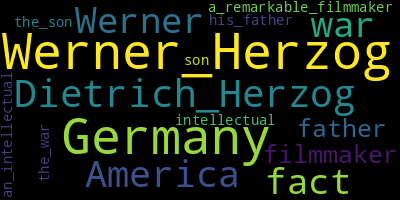

In [19]:
wordcloud = render.generate_wordcloud()
display(wordcloud.to_image())

## cluster communities in the lemma graph

In the tutorial
<a href="https://towardsdatascience.com/how-to-convert-any-text-into-a-graph-of-concepts-110844f22a1a" target="_blank">"How to Convert Any Text Into a Graph of Concepts"</a>, 
Rahul Nayak uses the
<a href="https://en.wikipedia.org/wiki/Girvan%E2%80%93Newman_algorithm"><em>girvan-newman</em></a>
algorithm to split the graph into communities, then clusters on those communities.
His approach works well for unsupervised clustering of key phrases which have been extracted from many documents.
In contrast, Nayak was working with entities extracted from "chunks" of text, not with a text graph.

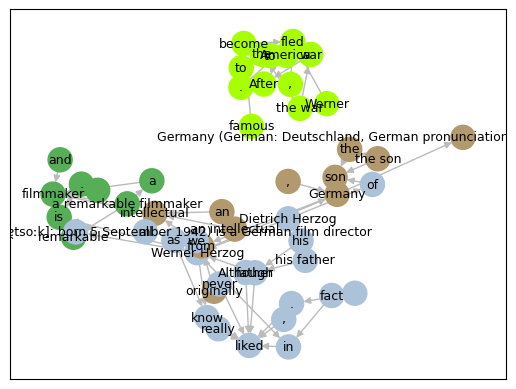

In [20]:
render.draw_communities();

## statistical stack profile instrumentation

In [21]:
profiler.stop()

In [22]:
profiler.print()


  _     ._   __/__   _ _  _  _ _/_   Recorded: 12:22:23  Samples:  14147
 /_//_/// /_\ / //_// / //_'/ //     Duration: 137.122   CPU time: 101.567
/   _/                      v4.6.1

Program: /Users/paco/src/textgraph/venv/lib/python3.9/site-packages/ipykernel_launcher.py -f /Users/paco/Library/Jupyter/runtime/kernel-efae0aae-138b-48b3-8183-5c6f2677c427.json

137.125 _UnixSelectorEventLoop._run_once  asyncio/base_events.py:1815
├─ 72.599 KqueueSelector.select  selectors.py:554
│     [2 frames hidden]  selectors, <built-in>
│        72.599 kqueue.control  <built-in>
└─ 64.526 Handle._run  asyncio/events.py:78
      [12 frames hidden]  asyncio, ipykernel, IPython
         63.505 ZMQInteractiveShell.run_ast_nodes  IPython/core/interactiveshell.py:3391
         ├─ 45.810 <module>  ../ipykernel_28865/2510744831.py:1
         │  └─ 45.807 TextGraph.infer_relations  textgraph/doc.py:651
         │     └─ 44.386 TextGraph._iter_rel_rebel  textgraph/doc.py:597
         │        ├─ 27.160 Rebe

## outro

_\[ more parts are in progress, getting added to this demo \]_